In [43]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from commons import (
    DATASET_CLEAN_LOCATION,
    DATASET_CLEAN_UNDERSAMPLING_LOCATION,
    MODEL_FOLDER,
    Datasets,
    ModelML,
    vectorize_and_split_dataset,
)
from numpy.typing import NDArray
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, learning_curve

# Model Evaluation

I import the datasets to conduct a more in-depth analysis of the results.


In [44]:
df = pd.read_csv(DATASET_CLEAN_LOCATION)
df_undersampling = pd.read_csv(DATASET_CLEAN_UNDERSAMPLING_LOCATION)

df_bow = vectorize_and_split_dataset(df, CountVectorizer())
df_bow_undersampling = vectorize_and_split_dataset(df_undersampling, CountVectorizer())
df_tfidf = vectorize_and_split_dataset(df, TfidfVectorizer())
df_tfidf_undersampling = vectorize_and_split_dataset(df_undersampling, TfidfVectorizer())

I import the models saved during the training step.


In [ ]:
PATH_MODEL_FOLDER = Path(MODEL_FOLDER)

with (PATH_MODEL_FOLDER / "nb_bow.pkl").open("rb") as f:
    nb_bow = pickle.load(f)

with (PATH_MODEL_FOLDER / "nb_bow_und.pkl").open("rb") as f:
    nb_bow_und = pickle.load(f)

with (PATH_MODEL_FOLDER / "lr_tfidf.pkl").open("rb") as f:
    lr_tfidf = pickle.load(f)

with (PATH_MODEL_FOLDER / "lr_tfidf_und.pkl").open("rb") as f:
    lr_tfidf_und = pickle.load(f)

I perform cross-validation to ensure that the results are not simply due to a lucky train-test split.


In [63]:
scores_nb_bow = cross_val_score(nb_bow, df_bow.X, df_bow.y, cv=5, scoring="accuracy")
print(f"Cross-validation accuracy nb_bow: {scores_nb_bow.mean():.4f} ± {scores_nb_bow.std():.4f}")
scores_nb_bow_und = cross_val_score(nb_bow_und, df_bow_undersampling.X, df_bow_undersampling.y, cv=5, scoring="accuracy")
print(f"Cross-validation accuracy nb_bow undersampling: {scores_nb_bow_und.mean():.4f} ± {scores_nb_bow_und.std():.4f}")

scores_lr_tfidf = cross_val_score(lr_tfidf, df_tfidf.X, df_tfidf.y, cv=5, scoring="accuracy")
print(f"Cross-validation accuracy lr_tfidf: {scores_lr_tfidf.mean():.4f} ± {scores_lr_tfidf.std():.4f}")
scores_lr_tfidf_und = cross_val_score(lr_tfidf_und, df_tfidf_undersampling.X, df_tfidf_undersampling.y, cv=5, scoring="accuracy")
print(f"Cross-validation accuracy lr_tfidf undersampling: {scores_lr_tfidf_und.mean():.4f} ± {scores_lr_tfidf_und.std():.4f}")

Cross-validation accuracy nb_bow: 0.9660 ± 0.0029
Cross-validation accuracy nb_bow undersampling: 0.9872 ± 0.0089
Cross-validation accuracy lr_tfidf: 0.9938 ± 0.0018
Cross-validation accuracy lr_tfidf undersampling: 0.9707 ± 0.0121


I display the confusion matrices for the four model configurations to better understand their classification performance. The performance is nearly identical across all models. I choose Bag of Words with Multinomial Naive Bayes as the production model due to its simplicity and explainability.



In [64]:
def print_cm_report(model: ModelML, dataset: Datasets, title: str) -> None:
    """
    Print the classification report and plot the confusion matrix for a given model.

    This function evaluates a trained classification model on the provided test dataset.
    It computes the predicted labels, displays a confusion matrix using Seaborn, and
    prints a detailed classification report including precision, recall, and F1-score.

    Args:
        model (ModelML): A trained classification model implementing the predict method.
        dataset (Datasets): A container with the test features and true labels.
        title (str): A title for the confusion matrix plot.

    Returns:
        None

    """
    y_pred = model.predict(dataset.X_t)
    cm = confusion_matrix(dataset.y_t, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Italian", "Italian"], yticklabels=["Not Italian", "Italian"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print(classification_report(dataset.y_t, y_pred, target_names=["Not Italian", "Italian"]))

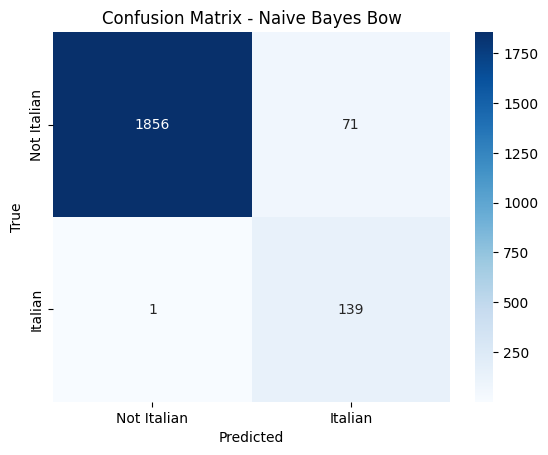

              precision    recall  f1-score   support

 Not Italian       1.00      0.96      0.98      1927
     Italian       0.66      0.99      0.79       140

    accuracy                           0.97      2067
   macro avg       0.83      0.98      0.89      2067
weighted avg       0.98      0.97      0.97      2067



In [65]:
print_cm_report(nb_bow, df_bow, "Naive Bayes Bow")

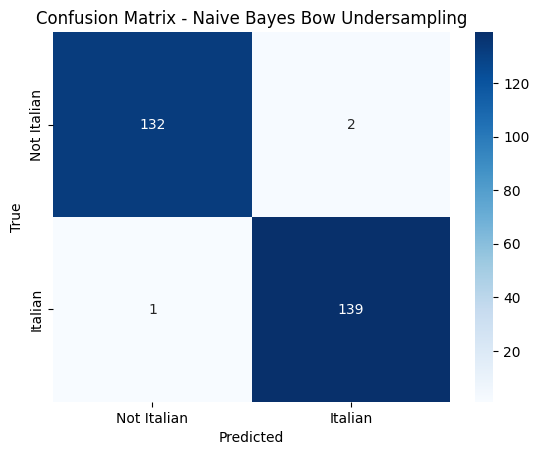

              precision    recall  f1-score   support

 Not Italian       0.99      0.99      0.99       134
     Italian       0.99      0.99      0.99       140

    accuracy                           0.99       274
   macro avg       0.99      0.99      0.99       274
weighted avg       0.99      0.99      0.99       274



In [66]:
print_cm_report(nb_bow_und, df_bow_undersampling, "Naive Bayes Bow Undersampling")

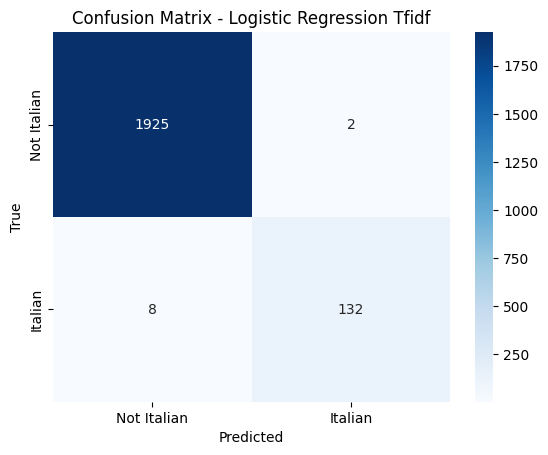

              precision    recall  f1-score   support

 Not Italian       1.00      1.00      1.00      1927
     Italian       0.99      0.94      0.96       140

    accuracy                           1.00      2067
   macro avg       0.99      0.97      0.98      2067
weighted avg       1.00      1.00      1.00      2067



In [67]:
print_cm_report(lr_tfidf, df_tfidf, "Logistic Regression Tfidf")

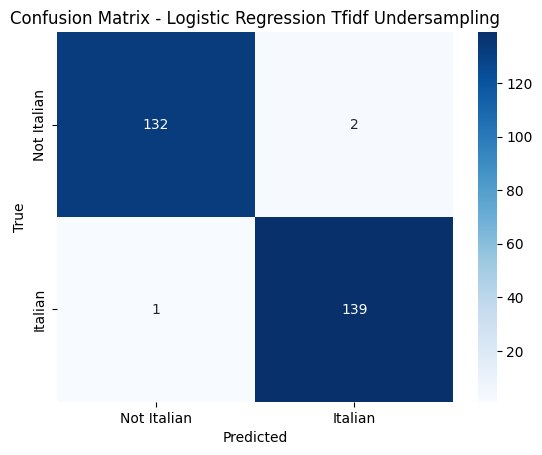

              precision    recall  f1-score   support

 Not Italian       0.99      0.99      0.99       134
     Italian       0.99      0.99      0.99       140

    accuracy                           0.99       274
   macro avg       0.99      0.99      0.99       274
weighted avg       0.99      0.99      0.99       274



In [68]:
print_cm_report(lr_tfidf_und, df_tfidf_undersampling, "Logistic Regression Tfidf Undersampling")

I plot the ROC curves along with the AUC scores to evaluate the model performances. I show two visualizations. The second one is zoomed in to better observe the differences between the models.



In [ ]:
models = {
    "NB BoW": nb_bow,
    "NB BoW Und": nb_bow_und,
    "LogReg TF-IDF": lr_tfidf,
    "LogReg TF-IDF Und": lr_tfidf_und,
}

Xs = {
    "NB BoW": df_bow.X_t,
    "NB BoW Und": df_bow_undersampling.X_t,
    "LogReg TF-IDF": df_tfidf.X_t,
    "LogReg TF-IDF Und": df_tfidf_undersampling.X_t,
}

ys = {
    "NB BoW": df_bow.y_t,
    "NB BoW Und": df_bow_undersampling.y_t,
    "LogReg TF-IDF": df_tfidf.y_t,
    "LogReg TF-IDF Und": df_tfidf_undersampling.y_t,
}


def build_auc_plot(models: dict[str, ModelML], Xs: dict[str, csr_matrix], ys: dict[str, NDArray[np.float64]]) -> None:
    """
    Build ROC curves for multiple classification models.

    This function builds the ROC curves for a dictionary of trained classification models, each evaluated on
    its corresponding feature matrix. The function computes the AUC for each model and includes it in the plot legend.

    Args:
        models (dict[str, ModelML]): A dictionary of trained models keyed by their names.
        Xs (dict[str, csr_matrix]): A dictionary of test feature matrices corresponding to each model.
        ys (dict[str, NDArray[np.float64]): A dictionary with the true binary labels for the test set.

    Returns:
        None

    """
    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        y_probs = model.predict_proba(Xs[name])[:, 1]
        fpr, tpr, _ = roc_curve(ys[name], y_probs)
        auc = roc_auc_score(ys[name], y_probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.6f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - Classificatori")
    plt.legend(loc="lower right")
    plt.grid(visible=True)

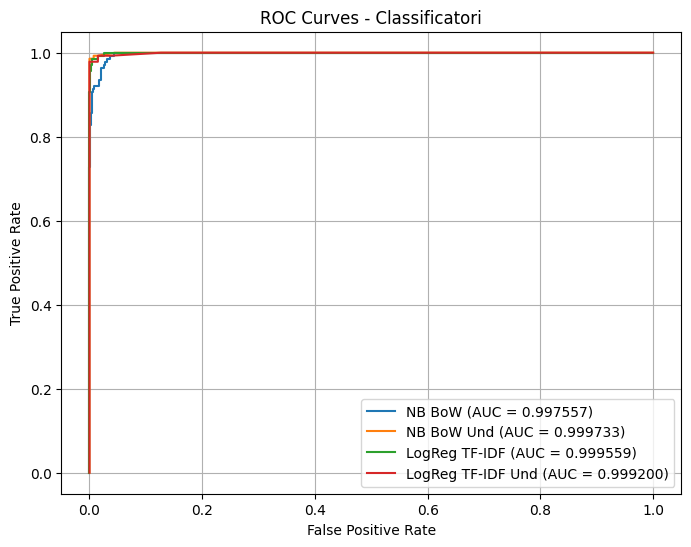

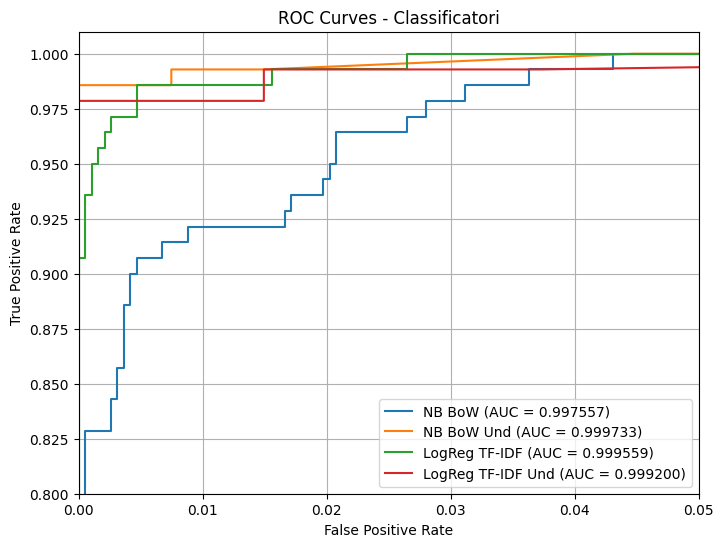

In [77]:
build_auc_plot(models, Xs, ys)
plt.show()
build_auc_plot(models, Xs, ys)
plt.xlim(0.0, 0.05)
plt.ylim(0.80, 1.01)
plt.show()

I plot the learning curves, which show that after a certain number of iterations, the model stabilizes at a consistent performance level.


In [78]:
def plot_learning_curve(
    estimator: ModelML,
    X: csr_matrix,
    y: NDArray[np.float64],
    title: str,
    cv: int = 5,
    scoring: str = "accuracy",
) -> None:
    """
    Plot the learning curve of a machine learning model.

    This function evaluates the model performance on both the training and
    validation sets as the number of training samples increases. It helps
    to diagnose whether the model is underfitting, overfitting, or
    benefiting from more training data.

    Args:
        estimator (ModelML): The machine learning model to evaluate.
        X (csr_matrix): Feature matrix in sparse format.
        y (NDArray[np.float64]): Target labels.
        title (str): Title of the plot.
        cv (int, optional): Number of cross-validation folds. Defaults to 5.
        scoring (str, optional): Scoring metric to evaluate model performance. Defaults to "accuracy".

    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1,
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.plot(train_sizes, train_mean, label="Training score")
    plt.plot(train_sizes, val_mean, label="Validation score")
    plt.xlabel("Training set size")
    plt.ylabel(scoring.capitalize())
    plt.title(title)
    plt.legend()
    plt.grid(visible=True)
    plt.show()

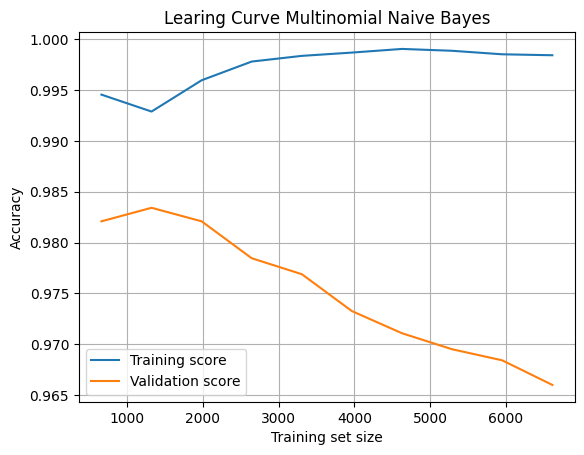

In [79]:
plot_learning_curve(nb_bow, df_bow.X, df_bow.y, "Learing Curve Multinomial Naive Bayes")

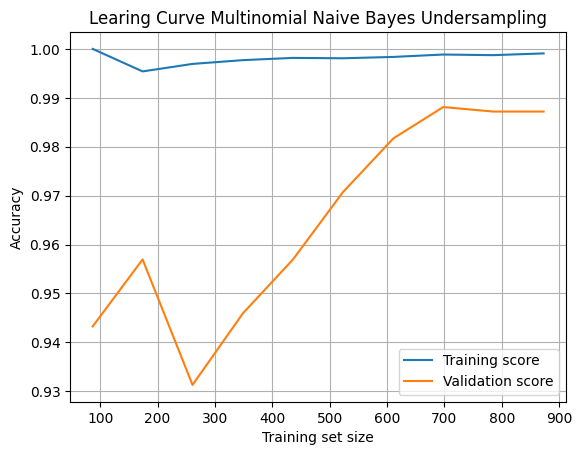

In [81]:
plot_learning_curve(nb_bow_und, df_bow_undersampling.X, df_bow_undersampling.y, "Learing Curve Multinomial Naive Bayes Undersampling")

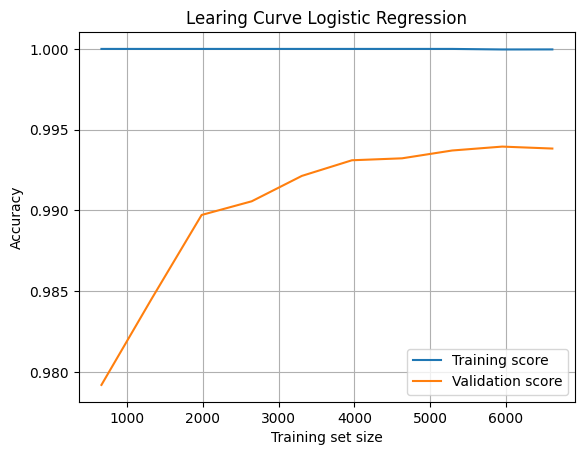

In [82]:
plot_learning_curve(lr_tfidf, df_tfidf.X, df_tfidf.y, "Learing Curve Logistic Regression")

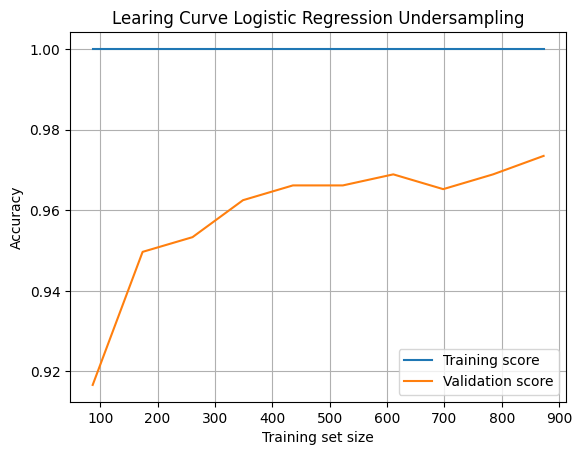

In [83]:
plot_learning_curve(lr_tfidf_und, df_tfidf_undersampling.X, df_tfidf_undersampling.y, "Learing Curve Logistic Regression Undersampling")